# Advanced Coupled Mode Equations models

This tutorial demonstrates how to use the advanced CMEs models to simulate the nonlinear response of a TWPA. We'll explore extended mode systems that go beyond the basic pump-signal-idler configuration to include pump harmonics, frequency conversion processes, and higher-order effects.

### Overview

While the basic 3-wave mixing (3WM) model provides a good starting point for TWPA analysis, real devices exhibit more complex behavior due to:

* **Pump harmonics**: 2nd, 3rd, and higher harmonics of the pump frequency
* **Frequency conversion**: Processes like pump + signal, pump + idler
* **Signal/idler harmonics**: Higher harmonics of signal and idler modes
* **Device imperfections**: Losses and reflections throughout the transmission line

The `twpasolver` library handles these effects automatically through its `ModeArray` system and advanced CME solvers.

### Initialize TWPAnalysis

First, let's load a KITWPA model and plot its response. Since we are going to consider higher order processes, we will initialize TWPAnalysis with a larger frequency span to capture pump harmonics.

(-20.0, 1.0)

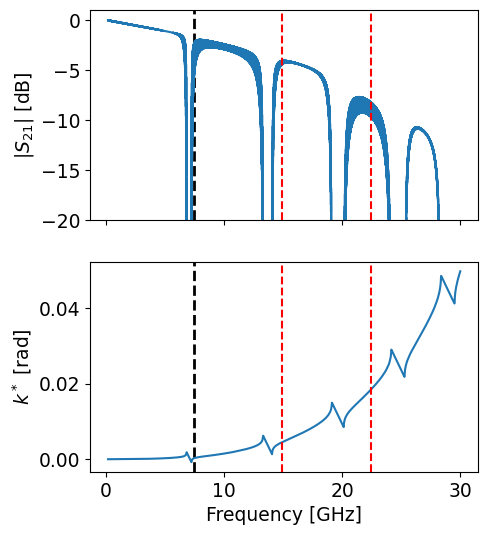

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from twpasolver import TWPAnalysis
from twpasolver.logger import log
from twpasolver.mathutils import dBm_to_I

log.setLevel(logging.WARNING)

plt.rcParams["font.size"] = 13.5
plt.rcParams["axes.axisbelow"] = True

twpa_file = "model_cpw_dartwars_13nm_Lk8_5.json"
a = TWPAnalysis(twpa=twpa_file, f_arange=(0.2, 30, 0.5e-3))
a.update_base_data()

optimal_pump = 7.4755
a.data["optimal_pump_freq"] = optimal_pump
ax = a.plot_response(pump_freq=optimal_pump)
for i in range(2):
    ax[i].axvline(2 * optimal_pump, ls="--", c="r")
    ax[i].axvline(3 * optimal_pump, ls="--", c="r")
ax[0].set_ylim(-20, 1)

Notice how we've extended the frequency range to 30 GHz to capture the 2nd and 3rd pump harmonics (marked with red dashed lines). The TWPA's dispersive response means these harmonics will have different propagation constants and can participate in additional mixing processes.

## ModeArrays and ModeArrayFactory

Properly describing the nonlinear response of TWPAs requires going beyond the basic CMEs system that considers only pump, signal and idler. `twpasolver` uses `ModeArray` objects to automatically build and solve CMEs systems including an arbitrary number of physical modes connected by frequency relationships.

A `ModeArray` has several key features:
* **Dependency graph management**: Organizes mode relations and identifies independent modes
* **Automatic parameter interpolation**: Extrapolates physical properties (frequency, wavenumber, losses) according to the relations
* **RWA term selection**: Automatically selects the 3WM and 4WM terms that satisfy the Rotating Wave Approximation when solving the CMEs
* **Symbolic frequency propagation**: Updates all related mode frequencies in O(n) time using pre-computed expressions

The `ModeArrayFactory` helps set up custom mode arrays or create standard extended mode collections.

Here's how to set up a ModeArray with custom defined modes and relations:

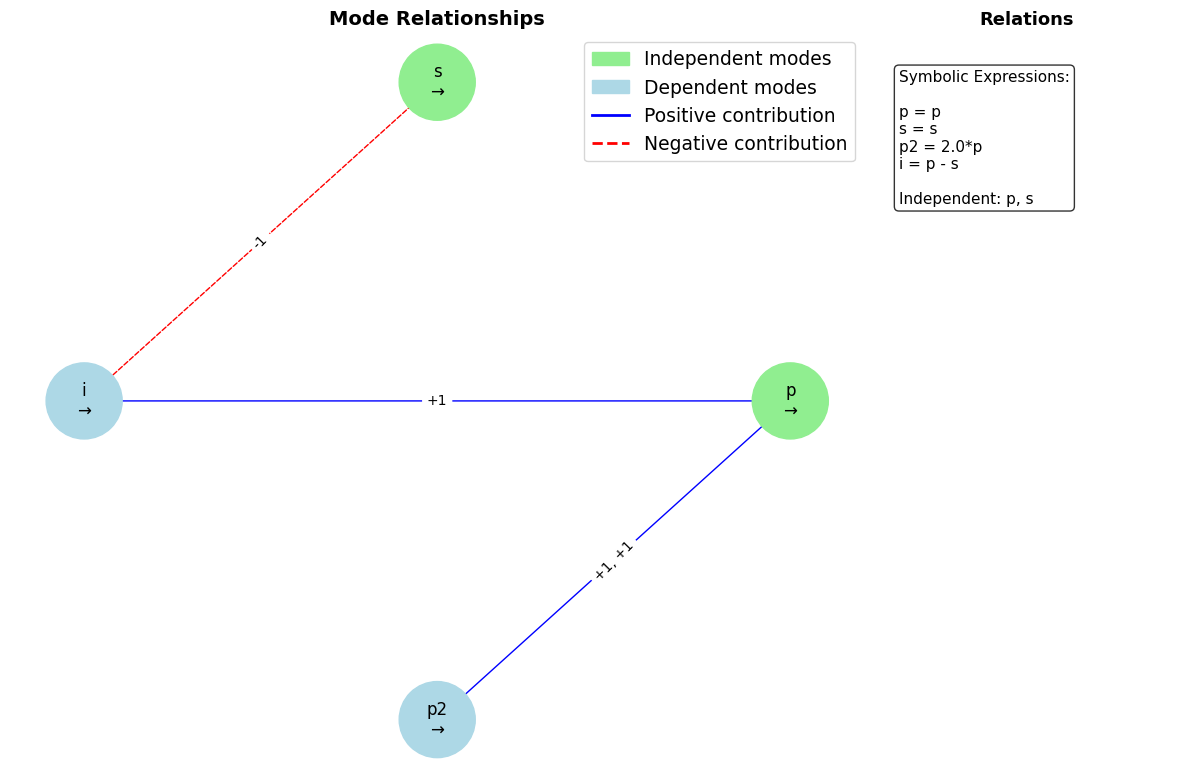

In [2]:
from twpasolver.modes_rwa import ModeArrayFactory

mode_labels = ["p", "s", "i", "p2"]
mode_relations = [["i", "p-s"], ["p2", "p+p"]]
mode_array_p2 = ModeArrayFactory.create_custom(
    a.data,
    mode_labels=mode_labels,
    mode_directions=[1, 1, 1, 1],
    relations=mode_relations,
)
mode_array_p2.plot_mode_relations(layout="circular")

The graph shows the mode relationships where:
* **Green nodes**: Independent modes (pump `p` and signal `s`)
* **Blue nodes**: Dependent modes (idler `i` and 2nd pump harmonic `p2`)
* **Blue arrows**: Positive frequency contributions
* **Red dashed arrows**: Negative frequency contributions

The symbolic expressions on the right show how each mode's frequency depends on the independent modes.

For more realistic simulations, you should consider pump harmonics, frequency conversion processes and signal/idler harmonics. The `create_extended_3wm` method creates a comprehensive set of modes automatically:

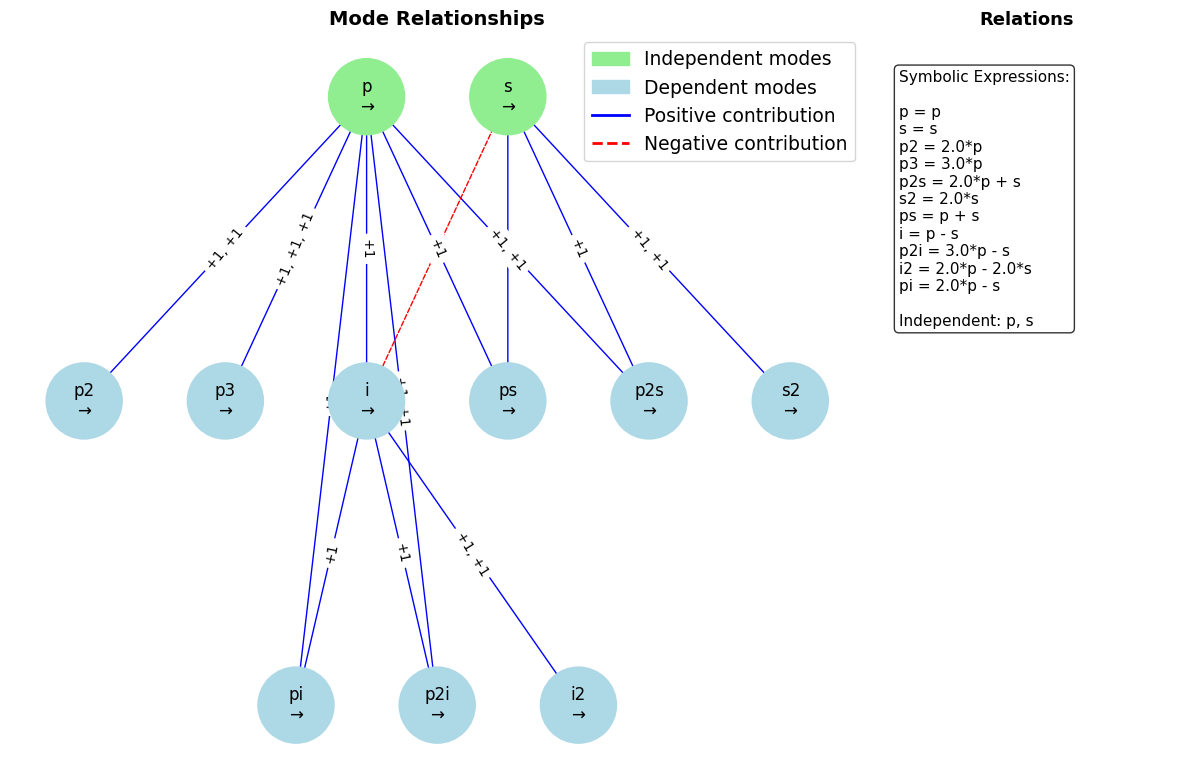

In [3]:
mode_array = ModeArrayFactory.create_extended_3wm(
    a.data, n_pump_harmonics=2, n_frequency_conversion=2, n_signal_harmonics=1
)
mode_array.plot_mode_relations(show_frequencies=False)
a.add_mode_array("gain_extended", mode_array)

This extended mode array includes:
* **Pump harmonics**: `p`, `p2`, `p3` (fundamental, 2nd and 3rd harmonic)
* **Basic 3WM**: `s`, `i` (signal and idler)
* **Frequency conversion**: `ps` (p+s), `pi` (p+i), and higher order processes generated by the pump harmonics
* **Signal harmonics**: `s2`, `i2` (first harmonics of signal and idler)

The hierarchical layout shows the dependency relationships, with independent modes at the top and increasingly complex derived modes below them.

## Gain comparison with different models

You can use the `model` parameter of the `gain` analysis function to specify which CME model to use. The library provides four models with increasing complexity:

* **minimal_3wm**: Basic pump-signal-idler model (fastest)
* **general_ideal**: Extended modes without losses or reflections
* **general_loss_only**: Extended modes with losses but no reflections  
* **general**: Full model with losses and reflections (most accurate but slow)

Once compiled, even simulations with large numbers of modes are quite fast thanks to Numba acceleration:

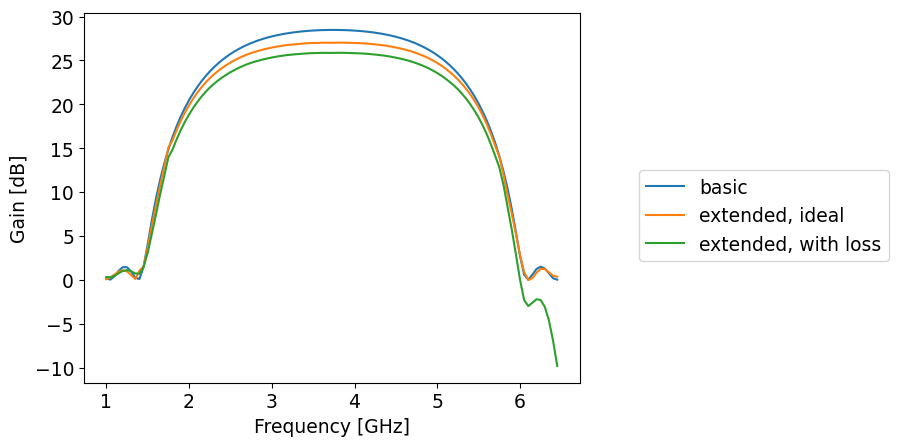

In [4]:
s_arange = np.arange(1, 6.5, 0.05)

res_gain_base = a.gain(signal_freqs=s_arange, Is0=1e-6, pump=optimal_pump)
ax = a.plot_gain()
res_gain_extended = a.gain(
    signal_freqs=s_arange,
    Is0=1e-6,
    pump=optimal_pump,
    model="general_ideal",
    mode_array_config="gain_extended",
)
res_gain_with_loss = a.gain(
    signal_freqs=s_arange,
    Is0=1e-6,
    pump=optimal_pump,
    model="general_loss_only",
    mode_array_config="gain_extended",
)

ax.plot(s_arange, res_gain_extended["gain_db"])
ax.plot(s_arange, res_gain_with_loss["gain_db"])
ax.legend(
    ["basic", "extended, ideal", "extended, with loss"], bbox_to_anchor=(1.1, 0.6)
)

The most realistic model takes into account both losses and reflections in the device, but requires more computation time (typically ~10x the ideal models):

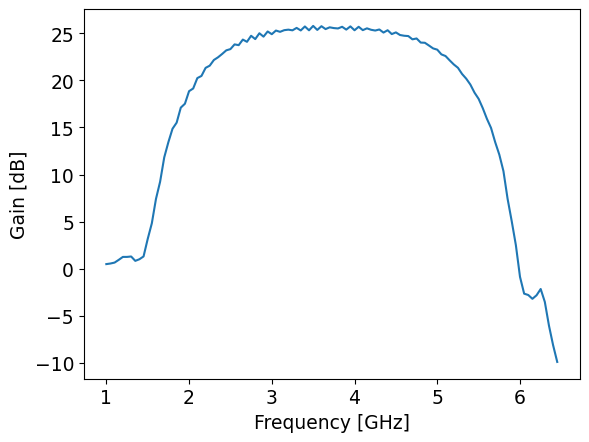

In [5]:
res_gain_with_reflections_wide = a.gain(
    signal_freqs=s_arange,
    Is0=1e-6,
    pump=optimal_pump,
    model="general",
    mode_array_config="gain_extended",
)
ax = a.plot_gain()

The full model including reflections can reveal fine structure in the gain profile that other models miss. For critical applications requiring quantitative agreement with experiment, this model provides the highest accuracy.

Let's zoom in on a narrower frequency range to see the gain ripples:

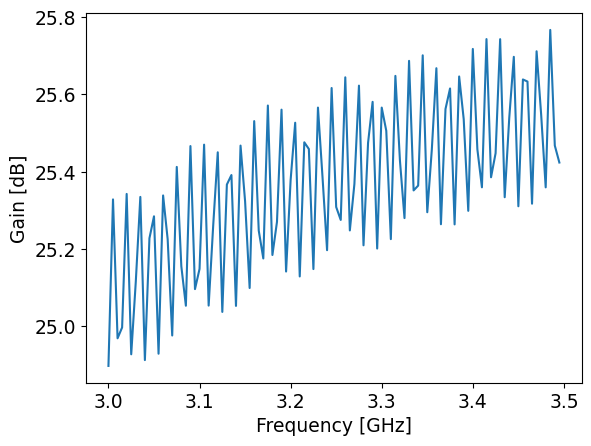

In [6]:
s_arange = np.arange(3, 3.5, 0.005)
res_gain_with_reflections_narrow = a.gain(
    signal_freqs=s_arange,
    Is0=1e-6,
    pump=optimal_pump,
    model="general",
    mode_array_config="gain_extended",
)
ax = a.plot_gain()

## Mode Current Analysis

Another useful feature of `TWPAnalysis` is the ability to plot the average currents for each mode as a function of position along the transmission line. This helps identify which processes are most relevant to the simulated response and understand the energy flow between different modes:

<Axes: title={'center': 'Mean Mode Currents vs Cell Number\nPump Frequency: 7.4755 GHz'}, xlabel='Cell Number', ylabel='Current (dBm)'>

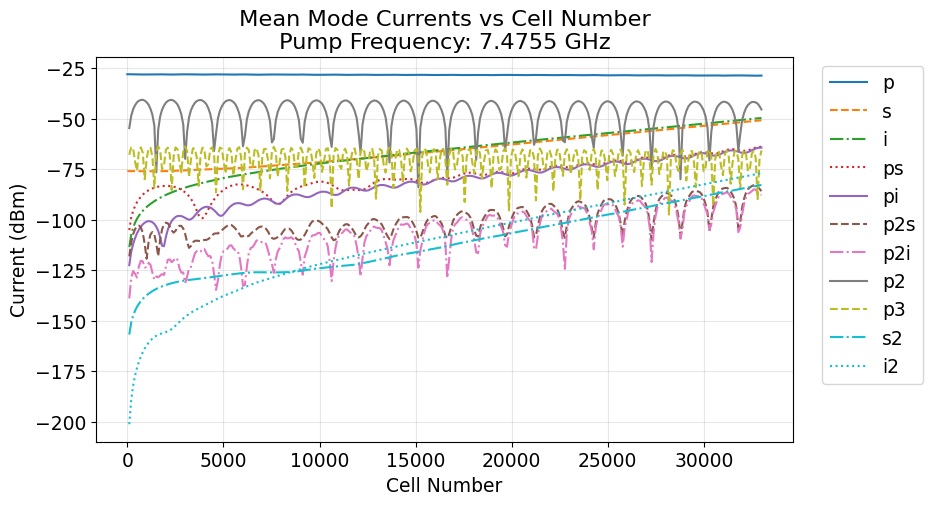

In [7]:
a.plot_mode_currents()

The mode currents plot can show:
* **Pump depletion**: The pump current typically decreases along the line as energy is transferred to signal and idler or is dissipated in a lossy device
* **Signal amplification**: The signal current grows exponentially in the gain region
* **Idler generation**: The idler current increases as the parametric process generates idler photons
* **Harmonic contributions**: Higher-order modes show their relative importance

Modes with negligible current levels throughout the device can often be safely excluded from the analysis to improve computational efficiency.